In [3]:
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import zuko
import lampe.inference, lampe.utils
from itertools import islice
import flowjax
from flowjax.flows import BlockNeuralAutoregressiveFlow, CouplingFlow
from flowjax.train_utils import train_flow
import jax.random as random
import flowjax.distributions, flowjax.flows
import jax
from numpyro.distributions import (
    Distribution,
    Normal,
    Bernoulli,
    Cauchy,
    constraints,
)
from flowjax.distributions import Distribution as FlowJaxDist
import matplotlib.pyplot as plt

In [4]:
N = 50000
prior_over_mu = zuko.distributions.Normal(torch.Tensor([0.0]), torch.Tensor([25.0]))

Utils

In [5]:
def true_data_generating_process():
    """Computes x = (mean,var) of a sample of size 100 drawn from N(mu, 2) and mu drawn from a prior

    Returns:
        tuple: x, mu
    """
    mu = torch.distributions.Normal(torch.Tensor([0]), torch.Tensor([1])).sample((1, )).detach().item()
    dist = torch.distributions.Normal(mu, 2.0)
    sample = dist.sample((100, ))
    mean, var = torch.mean(sample).item(), torch.var(sample).item()
    x = mean, var
    return x, mu

Simulation (line 1 & 2 of Algorithm 1)

In [6]:
def simulator(thetas: torch.Tensor):
    """Simulator, maps theta -> x = (mean, var)

    Args:
        thetas (torch.Tensor): Parameters

    Returns:
        torch.Tensor: Tensor of size (theta.size, 2) of (mean, var)
    """
    N = thetas.size()[0]
    x = torch.empty((N, 2))
    for i, theta in enumerate(thetas):
        dist = torch.distributions.Normal(theta, 1.0)
        samples = dist.sample((100,))
        means, var = torch.mean(samples), torch.var(samples)
        x[i][0], x[i][1] = means, var
    return x

def scale(quantity):
    '''
    Standardizes the quantity
    '''
    means, std = quantity.mean(axis=0), quantity.std(axis=0)
    quantity = quantity - means
    quantity = quantity/std
    return quantity


#Raw simulations
theta_raw = prior_over_mu.sample((N, ))
x_raw = simulator(theta_raw)
#Standardized versions
theta = scale(theta_raw)
x = scale(x_raw)
dataset = lampe.data.JointDataset(theta, x)


#True observations 
y_raw = torch.tensor([ true_data_generating_process()[0] for j in range(N//10) ])
y = scale(y_raw)

theta_test = scale(prior_over_mu.sample((N//10, )))
x_test = scale(simulator(theta_test))
dataset_test = lampe.data.JointDataset(theta_test, x_test)

'''Creates a 'true' dataset (theta*, x*) ~ p(theta, x)'''
y_star_list = []
theta_star_list = []
for i in range(N//10):
    y_star, theta_star = true_data_generating_process()
    y_star_list.append(y_star)
    theta_star_list.append(theta_star)
y_star_raw = torch.tensor(y_star_list)
theta_star_raw = torch.tensor(theta_star_list)
theta_star = scale(theta_star_raw)
y_star = scale(y_star_raw)
dataset_star = lampe.data.JointDataset(theta_star.unsqueeze(1), y_star)

Train NPE q(theta|x) on the simulated dataset {(thetai, xi)}, i=1, ... N
Uses a neural spline flow defining the transform on the interval [-5, 5] using 10  spline segments and 5 coupling layers. The base of the flow is a standard Gaussian distribution. 

In [7]:
def build_nsf(features, context):
    """Callable to isntanciate the NPE with NSFs"""
    return zuko.flows.NSF(features, context, bins=10, transforms=5)
q_NPE = lampe.inference.NPE(theta_dim = 1, x_dim=2, build=build_nsf)

In [8]:
#Param for training
max_epochs = 50
learning_rate_NSF = 5*10e-4
batch_size = 256
#Optim
optimizer = torch.optim.Adam(q_NPE.parameters(), learning_rate_NSF)
step = lampe.utils.GDStep(optimizer)
#Creates the loader
loader = lampe.data.DataLoader(dataset, batch_size, shuffle=True)
loss = lampe.inference.NPELoss(q_NPE)

#For early stopping 
with torch.no_grad():
    min_loss = loss(theta_test, x_test)
time_to_min=1
min_loss_list = [min_loss]
patience = 5 

q_NPE.train()

for epoch in range(max_epochs):
    loss_epoch = 0
    for theta, x_batch in loader:
        losses = loss(theta, x_batch)
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        loss_epoch += losses
    print(f" Epoch {epoch} ")
    
    with torch.no_grad():
        loss_test = loss(theta_test, x_test)
        min_loss_list.append(loss_test)
        
        if len(min_loss_list) - np.argmin(min_loss_list) > patience:
            print(f"Early stop at epoch {epoch}")
            break
        
q_NPE.eval()

 Epoch 0 
 Epoch 1 
 Epoch 2 
 Epoch 3 
 Epoch 4 
 Epoch 5 
Early stop at epoch 5


NPE(
  (flow): NSF(
    (transforms): ModuleList(
      (0-4): 5 x MaskedAutoregressiveTransform(
        (base): MonotonicRQSTransform(bins=10)
        (order): [0]
        (hyper): MaskedMLP(
          (0): MaskedLinear(in_features=3, out_features=64, bias=True)
          (1): ReLU()
          (2): MaskedLinear(in_features=64, out_features=64, bias=True)
          (3): ReLU()
          (4): MaskedLinear(in_features=64, out_features=29, bias=True)
        )
      )
    )
    (base): DiagNormal(loc: tensor([0.]), scale: tensor([1.]))
  )
)

### Sampling theta here as in the 'classic' NPE framework (i.e. assuming no error)

In [ ]:
thetas_NPE = q_NPE.sample(x)

Train q(x) on {xi} i=1, ... N (so first gen the x)
For q(x) uses of a block neural autoregressive flow, single hidden layer of size 8D, x in R^d

In [11]:

batch_size = 256
max_epochs = 50
learning_rate_BNAF = 1e-2
epsilon = 1e-5
q_x_NF = zuko.flows.NAF(features = 2, context=0, hidden_features=[8]*2,transforms=1)
loader_x = torch.utils.data.DataLoader(x, batch_size=batch_size)

optimizer = torch.optim.Adam(q_x_NF.parameters(), 1e-2)

with torch.no_grad():
    min_loss = -q_x_NF().log_prob(x_test).mean()
min_loss_list = [min_loss]
for epoch in range(max_epochs):
    loss_epoch = 0
    print(f"Epoch = {epoch}")
    for x_batch in loader_x:
        loss =-q_x_NF().log_prob(x_batch).mean()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    with torch.no_grad():
        loss_test = -q_x_NF().log_prob(x_test).mean()
        min_loss_list.append(loss_test)
        if len(min_loss_list) - np.argmin(min_loss_list) > patience:
            print(f"Early stop at epoch {epoch}")
            break


Epoch = 0
Epoch = 1
Epoch = 2
Epoch = 3
Epoch = 4
Epoch = 5
Epoch = 6
Epoch = 7
Epoch = 8
Early stop at epoch 8


Sample x~m from p(x | y0) % p(y0 \ x) q(x), m = 1, ... M using MCMC

Spike and slab

In [14]:
M = 100000
warm_up_steps = 20000
traj_length = 1
target_acceptance_prob = 0.95

In [15]:
def spike_slab(y):
    rho = 1/2
    sigma = 0.01
    tau = 0.25
    x = q_x_NF().sample()
    z = torch.distributions.Bernoulli(rho).sample(y.shape)
    normal = torch.distributions.Normal(x,sigma)
    cauchy = torch.distributions.Cauchy(x, tau)
    mask = torch.zeros_like(z)
    mask[z==1] = 1
    mask[z==0] = 0
    sampled_values = torch.where(mask==1, cauchy.sample(z.shape), normal.sample(z.shape))
    return sampled_values.sum()
    

In [17]:

class MHQTransition(lampe.inference.MetropolisHastings):
    def q(self, x:torch.Tensor):
        return q_x_NF()

In [24]:
def p_y_given_x(x):
    z = torch.distributions.Bernoulli(1/2).sample(x.shape)
    res = 1
    for j,x_j in enumerate(x):
        zj=z[j]
        if not zj:
            dist=  torch.distributions.Normal(x_j, 0.01)
        else:
            dist = torch.distributions.Cauchy(x_j, 0.25)
        res *= dist.log_prob(y).exp().sum()
    return res
            
            

In [ ]:
import tqdm

In [44]:
sampler = MHQTransition(q_x_NF().sample(),f=p_y_given_x)
with torch.no_grad():
    xm_samples_ = [s for s in tqdm.tqdm(sampler(M+warm_up_steps,burn=warm_up_steps))]
    xm_samples_ = torch.stack(xm_samples_)

53548it [22:23, 39.85it/s]


KeyboardInterrupt: 

In [14]:
sampler = lampe.inference.MetropolisHastings(q_x_NF().sample(),f=spike_slab)
with torch.no_grad():
    xm_samples = [s for s in sampler(M+warm_up_steps,burn=warm_up_steps)]
    xm_samples = torch.stack(xm_samples)

KeyboardInterrupt: 

In [36]:
xm_samples_arr = xm_samples.detach().numpy()
xm_samples_arr

array([[ 0.8244139 ,  0.01038768],
       [-0.59854394, -0.6725981 ],
       [-1.0299511 , -0.4994842 ],
       ...,
       [ 0.8339483 , -0.62175727],
       [ 0.35281512, -0.27730352],
       [ 0.39325714, -0.8362903 ]], dtype=float32)

In [37]:
class1 = np.load("/home/tux/rnpe/denoise_xm_paper.npy",allow_pickle=True)

In [38]:
class0 = xm_samples_arr

In [39]:
import sklearn
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
#class0 = np.load("/home/tux/rnpe/mycode/xmMCMCLampe.npy")
#class0 = x_samples
#class1 = np.load("/home/tux/rnpe/denoise_xm_paper.npy",allow_pickle=True)
#class0 = q_x_NF.forward().sample(class1.shape).detach().numpy()
class0_labels = np.zeros(len(class0))
class1_labels = np.ones(class1.shape[0])
data = np.concatenate((class0,class1), axis=0)
labels = np.concatenate((class0_labels, class1_labels), axis=0)
X_train, X_test, y_train, y_test = train_test_split(data,labels)

clf = QuadraticDiscriminantAnalysis()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
acc = sklearn.metrics.accuracy_score(y_test,y_pred)
acc

0.9547636363636364

Sample theta ~q(theta | xm), m = 1, ..., M

In [ ]:
with torch.no_grad():
    thetasm = q_NPE.sample(xm_samples)

In [ ]:
def my_coverage(q_NPE, theta_star, y_star, alpha):
    cov = 0
    for i in range(len(theta_star)):
        q = q_NPE(theta_star[i], y_star[i])
        cr = np.percentile(q.detach().numpy(), [100*alpha/2, 100*(1-alpha/2)])
        if theta_star[i] >= cr[0] and theta_star[i] <= cr[1]:
            cov +=1
    return cov

In [ ]:
xm_samples_ = xm_samples[0:5000]

In [ ]:
test = lampe.data.JointDataset(theta_star.unsqueeze_(1),xm_samples_)

100%|██████████| 5000/5000 [02:25<00:00, 34.31pair/s]


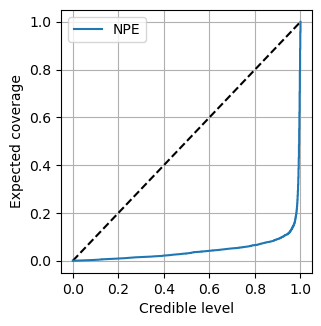

In [ ]:
from lampe.diagnostics import expected_coverage_mc, expected_coverage_ni
npe_levels, npe_coverages = expected_coverage_mc(q_NPE.flow, dataset_star)#TODO essayer ici de changer params
from lampe.plots import nice_rc, coverage_plot
fig = coverage_plot(npe_levels, npe_coverages, legend='NPE')

In [ ]:
#TODO Plot le NPE aussi mais il faut faire prendre les xm ?

from lampe.diagnostics import expected_coverage_mc, expected_coverage_ni
npe_levels, npe_coverages = expected_coverage_mc(q_NPE, test)#TODO essayer ici de changer params
from lampe.plots import nice_rc, coverage_plot
fig = coverage_plot(npe_levels, npe_coverages, legend='NPE')

  0%|          | 0/5000 [00:00<?, ?pair/s]


TypeError: forward() missing 1 required positional argument: 'x'

In [ ]:
q_x.bijection.inverse_and_log_abs_det_jacobian(x_jax[0])

(Array([-0.85242  ,  0.5124575], dtype=float32),
 Array(-0.03808814, dtype=float32))

In [ ]:
def compute_log_prob(flow, thetas, x):
    res = []
    for i, theta in enumerate(thetas.unsqueeze_(1)):
        xi = x[i]
        log_prob = flow.flow(xi).log_prob(theta) 
        res.append(log_prob.detach().item())
    return res

In [ ]:
log_probs_RNPE = compute_log_prob(q_NPE, theta_star, xm_samples)
log_probs_NPE = compute_log_prob(q_NPE, theta_star, x)

{'whiskers': [<matplotlib.lines.Line2D at 0x7fe1d77dcaf0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fe1d77eb070>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fe1d77dc850>,
 'medians': [<matplotlib.lines.Line2D at 0x7fe1d77eb5b0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fe1d77eb850>,
 'means': []}

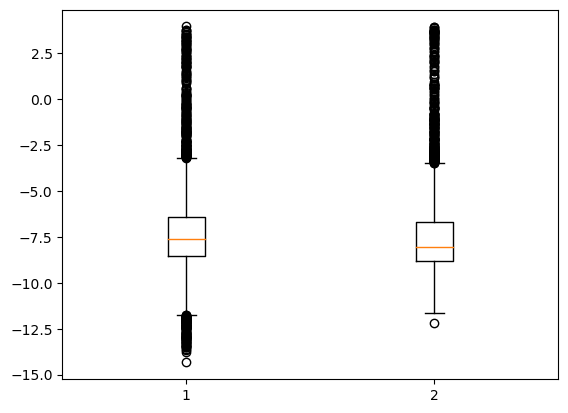

In [ ]:
plt.boxplot([log_probs_NPE, log_probs_RNPE])

Il faut aussi faire les 2 autres simu cad NPE (comme avant) et en mettant directement le modele d'erreur dans le simu

In [ ]:
def noisy_simulator():
    #Sample the parameters theta [mu]
    sigma = 0.01
    tau = 0.25
    rho = 1/2
    x_noisy_raw, theta_noisy_raw = x_raw, theta_raw
    x_noisy_test, theta_noisy_test = x_test, theta_test

    for i, x in enumerate(x_noisy_raw):
        spike_dist = torch.distributions.Normal(x, torch.Tensor([sigma]))
        slab_dist = torch.distributions.Cauchy(x, torch.Tensor([tau]))
        spike = ((1 - rho) *spike_dist.sample((1, )))[0]
        slab = (rho * slab_dist.sample((1, )))[0]
        x_noisy_raw[i] += spike + slab
    for i, x in enumerate(x_noisy_test):
        spike_dist = torch.distributions.Normal(x, torch.Tensor([sigma]))
        slab_dist = torch.distributions.Cauchy(x, torch.Tensor([tau]))
        spike = ((1 - rho) *spike_dist.sample((1, )))[0]
        slab = (rho * slab_dist.sample((1, )))[0]
        x_noisy_test += spike + slab
    x_noisy = scale(x_noisy_test)
    theta_noisy = scale(theta_noisy_raw)
    return x_noisy, theta_noisy, x_noisy_test, theta_noisy_test
        

In [ ]:
X_noisy, thetas, X_noisy_test, thetas_test = noisy_simulator()

In [ ]:
q_NPE_noisy = zuko.flows.NSF(features=1, context=2, bins=10, transforms=5) #TODO! Continuer ICI